junction_map = {

"1278": { "Device 1/nA":"A1A2", "Device 2/nA":"B7B8", "Device 3/nA":"C1C2", "Device 4/nA":"D7D8", "Device 5/nA":"E1E2", "Device 6/nA":"F7F8", "Device 7/nA":"G1G2", "Device 8/nA":"H7H8",
"Channel1":"A1A2", "Channel2":"B7B8", "Channel3":"C1C2", "Channel4":"D7D8", "Channel5":"E1E2", "Channel6":"F7F8", "Channel7":"G1G2", "Channel8":"H7H8" },

"3456": { "Device 1/nA":"A3A4", "Device 2/nA":"B5B6", "Device 3/nA":"C3C4", "Device 4/nA":"D5D6", "Device 5/nA":"E3E4", "Device 6/nA":"F5F6", "Device 7/nA":"G3G4", "Device 8/nA":"H5H6",
"Channel1":"A3A4", "Channel2":"B5B6", "Channel3":"C3C4", "Channel4":"D5D6", "Channel5":"E3E4", "Channel6":"F5F6", "Channel7":"G3G4", "Channel8":"H5H6" },

"5634": { "Device 1/nA":"A5A6", "Device 2/nA":"B3B4", "Device 3/nA":"C5C6", "Device 4/nA":"D3D4", "Device 5/nA":"E5E6", "Device 6/nA":"F3F4", "Device 7/nA":"G5G6", "Device 8/nA":"H3H4",
"Channel1":  "A5A6", "Channel2":"B3B4", "Channel3":"C5C6", "Channel4":"D3D4", "Channel5":"E5E6", "Channel6":"F3F4", "Channel7":"G5G6", "Channel8":"H3H4" },

"7812": { "Device 1/nA":"A7A8", "Device 2/nA":"B1B2", "Device 3/nA":"C7C8", "Device 4/nA":"D1D2", "Device 5/nA":"E7E8", "Device 6/nA":"F1F2", "Device 7/nA":"G7G8", "Device 8/nA":"H1H2",
 "Channel1":"A7A8", "Channel2":"B1B2", "Channel3":"C7C8", "Channel4":"D1D2", "Channel5":"E7E8", "Channel6":"F1F2", "Channel7":"G7G8", "Channel8":"H1H2" }
}

In [1]:
## IMPORT LIBRARIES
import numpy as np
from numpy import array, sign, zeros
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
from nptdms import TdmsFile
import pandas as pd
import os
from natsort import natsorted
import sys
#import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import savgol_filter
from scipy import io
from scipy import sparse
from scipy import stats
from scipy.sparse.linalg import spsolve
from scipy.linalg import solveh_banded
from statistics import mean
from scipy.interpolate import interp1d
from scipy.signal import chirp, find_peaks, peak_widths
import re
from matplotlib import gridspec
import pywt
from sklearn.decomposition import PCA
#from pyts.image import RecurrencePlot
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from PIL import Image
#from matplotlib import cm
#from ripser import Rips
#from persim import PersImage
#from persim import PersistenceImager

%matplotlib inline

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

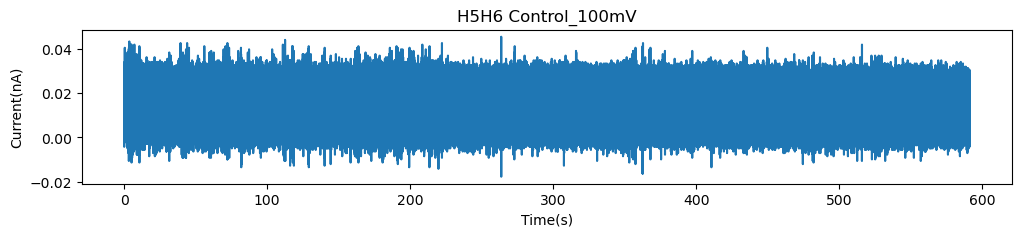

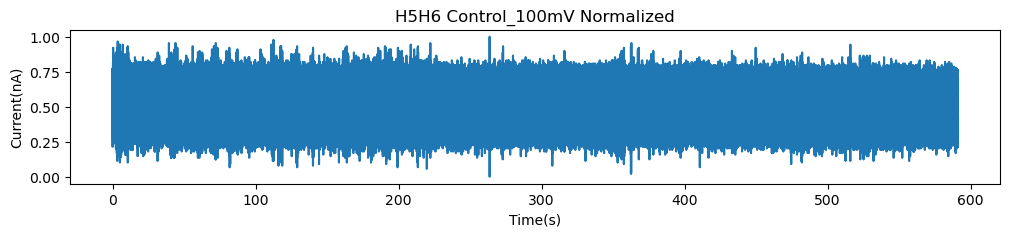

Control_100mV


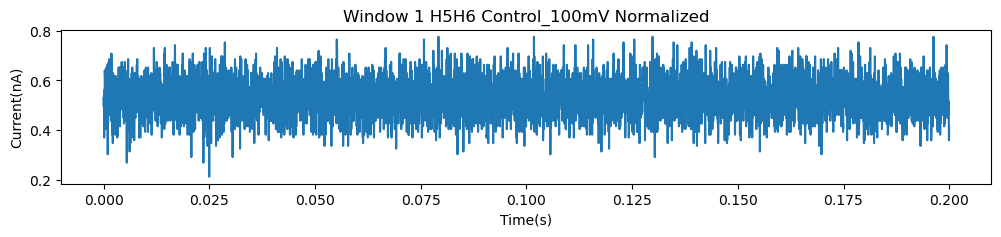

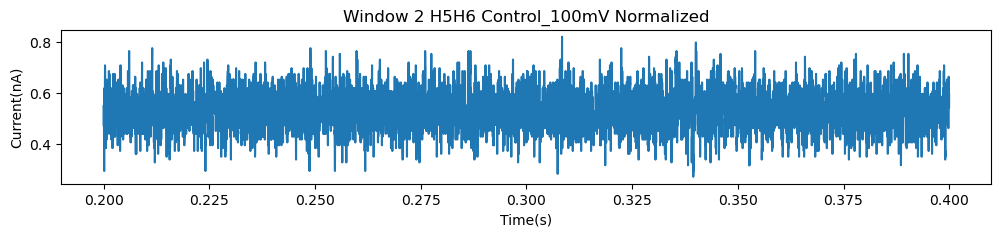

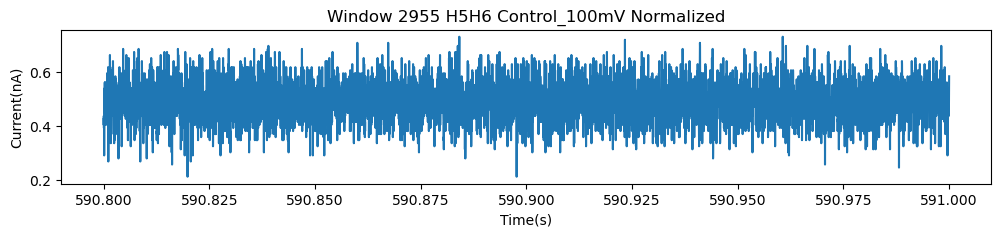

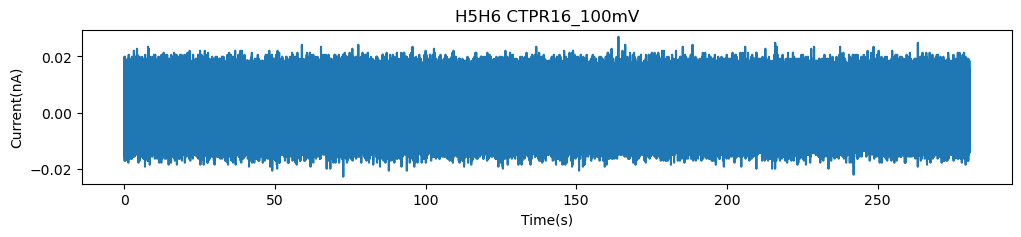

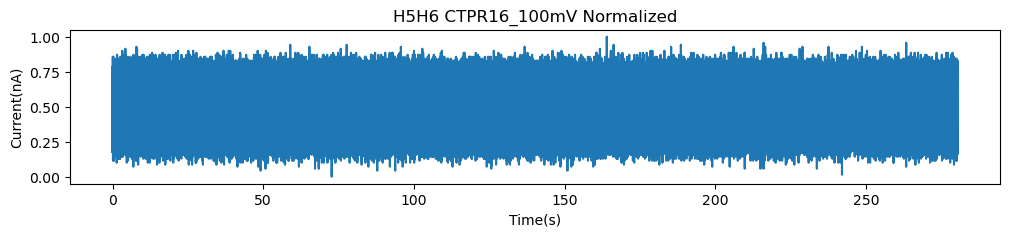

CTPR16_100mV


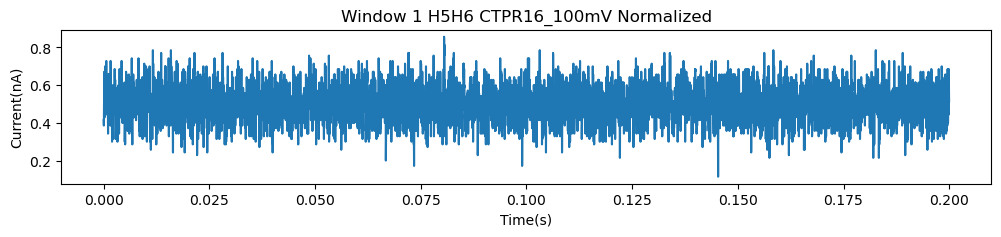

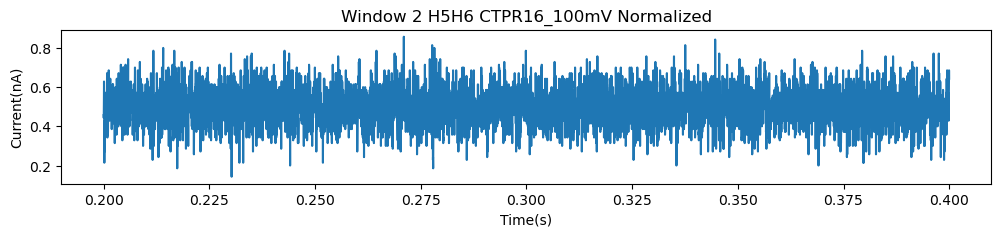

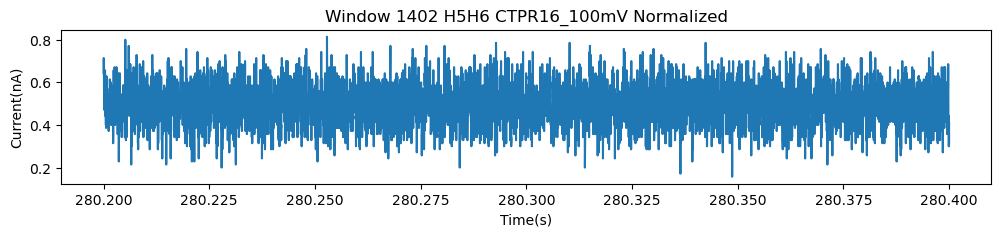

In [18]:
##all devices of interest
junction_name = '1278'
channel_name = 'Device 2/nA'
dev_num = 13
mv_val = 100
dev_name = 'B7B8'
folder_names = [f'./{junction_name}/Control_{mv_val}mV/',f'./{junction_name}/CTPR16_{mv_val}mV/']

for folder in folder_names:
    curr_data = []
    dataFiles = natsorted(os.listdir(folder))
    #print(folder,len(dataFiles))
    for file in dataFiles[1:]:    ##not taking first file (first 10 s) to ignore the capacitative rise in current
        #print(file)
        tdms_file = TdmsFile(folder + file) 
         
        condition = re.split('/',folder)[2]
        #print('Condition',condition)
        ## time
        time = tdms_file['Untitled'][ 'Time']
        time = time.data
        time = np.ndarray.tolist(time) 
        
        ## current
        current = tdms_file['Untitled'][f'{channel_name}']
        current = current.data 
        current = np.ndarray.tolist(current)
        curr_data.append(current)

    ## concatenate all 10 s signals
    ## taking values where current does not predominate in 0 nA region 
    curr_data_total = [item for sublist in curr_data for item in sublist]
    #curr_data_total_wo_dc_offset =  np.subtract(curr_data_total_in_air_100_mV, np.mean(curr_data_total_in_air_100_mV))
    time_data_total = np.linspace(0,len(curr_data_total),len(curr_data_total))/50000
    #print(len(curr_data_total))
    
    plt.figure(figsize= (12,2))
    plt.plot(time_data_total,curr_data_total)
    plt.xlabel('Time(s)')
    plt.ylabel('Current(nA)')
    plt.title(f'{dev_name} {condition}')
    plt.show()
    plt.close()
  
    curr_data_norm = NormalizeData(curr_data_total)
    plt.figure(figsize= (12,2))
    plt.plot(time_data_total,curr_data_norm)
    plt.xlabel('Time(s)')
    plt.ylabel('Current(nA)')
    plt.title(f'{dev_name} {condition} Normalized')
    plt.show()
    plt.close()    

    size = int(10000)   # 0.1s window size
    step = int(10000)   # 0.05 s overlap
    curr_slice = [curr_data_norm[i : i + size] for i in range(0, len(curr_data_total), step)]
    time_slice = [time_data_total[i : i + size] for i in range(0, len(time_data_total), step)]
    print(condition)
    
    #ts_table = np.empty((0,10000))

    for i in range(len(curr_slice)):
        
        X = np.asarray(curr_slice[i])
        t = np.asarray(time_slice[i])
        ##visualize windows
        #if len(X) == 10000:
        #    if i == 0 or i == 1 or i == (len(curr_slice)-2) or i == (len(curr_slice)-1):
        #        plt.figure(figsize= (12,2))
        #        plt.plot(t,X)
        #        plt.xlabel('Time(s)')
        #        plt.ylabel('Current(nA)')
        #        plt.title(f'Window {i+1} {dev_name} {condition} Normalized')
        #        plt.show()
        #        plt.close()
            
        ##save current vs time for each window
        if len(X) == 10000:

            ts_table = np.vstack([ts_table, X.flatten()])

    ### save the time series windows into csv        
    df = pd.DataFrame(ts_table)
    df['id'] = dev_name
    df['label'] = condition
    print(df.shape)
    df.to_csv(f'dev_{dev_num}_{condition}_norm_window_10000pts_overlap_0pts_ts.csv',index=False)
    print(df.head)